In [2]:
# Extract the file IDs from the URLs
file_id_1 = "1woK_LuOIipPQ9vwhCEd_SNh9EJkBCe2u"
file_id_2 = "1gesQepPirKYkd1i8cBMYaPOpyCxsDqJ-"

# Create a directory for the downloaded files
!mkdir -p downloaded_files

# Download the first file
!gdown --id {file_id_1} -O downloaded_files/file1.zip

# Download the second file
!gdown --id {file_id_2} -O downloaded_files/file2.zip

# Print the downloaded files to verify
!ls -la downloaded_files/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1woK_LuOIipPQ9vwhCEd_SNh9EJkBCe2u
From (redirected): https://drive.google.com/uc?id=1woK_LuOIipPQ9vwhCEd_SNh9EJkBCe2u&confirm=t&uuid=599fa418-6d28-4a8c-8009-e4ab063f473c
To: /content/downloaded_files/file1.zip
100% 37.8M/37.8M [00:00<00:00, 97.4MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gesQepPirKYkd1i8cBMYaPOpyCxsDqJ-
To: /content/downloaded_files/file2.zip
100% 9.42M/9.42M [00:00<00:00, 116MB/s]
total 46172
drwxr-xr-x 4 root root     4096 Apr 21 04:08 .
drwxr-xr-x 1 root r

In [3]:
# Unzip the first file
!unzip -o -q downloaded_files/file1 -d downloaded_files/file1_contents

# Unzip the second file
!unzip -o -q downloaded_files/file2 -d downloaded_files/file2_contents

In [4]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image processing
from PIL import Image
from skimage import transform, util, filters, color

# For splitting data
from sklearn.model_selection import train_test_split

# For evaluating results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
# Google colab patches
from google.colab.patches import cv2_imshow

## Prepro

In [6]:
train_data_list = ['downloaded_files/file1_contents/train/' + i for i in os.listdir('downloaded_files/file1_contents/train')]
test_data_list = ['downloaded_files/file2_contents/test/' + i for i in os.listdir('downloaded_files/file2_contents/test')]

train_data_y = [i.replace('-0.png','') for i in os.listdir('downloaded_files/file1_contents/train')]
test_data_y = [i.replace('-0.png','') for i in os.listdir('downloaded_files/file2_contents/test')]

### func clean

In [7]:
import cv2
import os
import numpy as np
from itertools import groupby
from operator import itemgetter
import imutils

def group_consecutive(indices, gap=1):
    groups = []
    start = indices[0]

    for i in range(1, len(indices)):
        if indices[i] - indices[i - 1] > gap:
            end = indices[i - 1]
            groups.append((start, end))
            start = indices[i]

    # Add the final group
    groups.append((start, indices[-1]))
    return groups

def cut_images(file_path, save_path, labels_list, tolerance=4):
    try:
        # Load image
        image_raw = cv2.imread(file_path)
        image = remove_black_pixels_set_to_surrounding(image_raw)

        # Create the sharpening kernel
        kernel = np.array([[-1, -1, -1],
        [-1, 9, -1],
        [-1, -1, -1]])

        # Apply the sharpening kernel to the image using filter2D
        image = cv2.filter2D(image, -1, kernel)

        if image is None:
            raise ValueError(f"Could not load image from path: {file_path}")

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
        inverted = 255 - binary

        # Get projections
        projection_x = np.sum(inverted, axis=0)
        projection_y = np.sum(inverted, axis=1)

        # Thresholding projection to find regions of interest
        mean_x = np.mean(projection_x)
        mean_y = np.mean(projection_y)

        char_indices_x = np.where(projection_x > mean_x)[0]
        char_indices_y = np.where(projection_y > mean_y)[0]

        grouped_x = group_consecutive(char_indices_x)
        grouped_y = group_consecutive(char_indices_y)

        # Error check: labels must match number of x segments
        if len(grouped_x) != len(labels_list):
            raise ValueError(f"Label count ({len(labels_list)}) does not match detected character segments ({len(grouped_x)}).")

        # Make output folder
        os.makedirs(save_path, exist_ok=True)

        height, width = inverted.shape

        # Use only the first row group (assumes one line of characters)
        if len(grouped_y) == 0:
            raise ValueError("No horizontal text regions found.")
        y_start, y_end = grouped_y[0]

        for idx, (x_start, x_end) in enumerate(grouped_x):
            x0 = max(0, x_start - tolerance)
            x1 = min(width - 1, x_end + tolerance)
            y0 = max(0, y_start - tolerance)
            y1 = min(height - 1, y_end + tolerance)

            crop = inverted[y0:y1+1, x0:x1+1]
            label = labels_list[idx]
            filename = os.path.join(save_path, f"{label}.png")
            cv2.imwrite(filename, crop)
            # print(f"Saved: {filename}")

    except Exception as e:
        # print(f"[ERROR] {e}")
        return "ERROR"

def group_consecutive(indices, gap=1):
    groups = []
    start = indices[0]

    for i in range(1, len(indices)):
        if indices[i] - indices[i - 1] > gap:
            end = indices[i - 1]
            groups.append((start, end))
            start = indices[i]

    # Add the final group
    groups.append((start, indices[-1]))
    return groups

def cut_images(file_path, save_path, labels_list, tolerance=4):
    """Cuts and saves regions of interest from an image."""
    try:
        image_raw = cv2.imread(file_path)
        image = remove_black_pixels_set_to_surrounding(image_raw)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)  # Use imutils to handle OpenCV version differences
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        if len(contours) != len(labels_list):
          raise ValueError('Inequal Length')

        for idx, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            roi = gray[y - tolerance : y + h + tolerance, x - tolerance : x + w + tolerance]
            filename = os.path.join(save_path, f"{labels_list[idx]}.png")
            cv2.imwrite(filename, roi)
        return None  # Indicate success

    except Exception as e:
        #print(f"[ERROR] {e}") #only print if debugging
        return "ERROR"
def remove_black_pixels(image):
  """
  Removes all black pixels (0, 0, 0) from an RGB image.

  Args:
    image: A NumPy array representing the RGB image (height, width, 3).

  Returns:
    A NumPy array representing the image with black pixels removed.
  """

  # Create a mask for non-black pixels
  mask = np.any(image != [0, 0, 0], axis=-1)

  # Apply the mask to the image
  result = image[mask]

  return result.reshape((-1, 3)) #reshape to a list of RGB pixels

def remove_black_pixels_white(image):
    """
    Removes all black pixels (0, 0, 0) from an RGB image and returns an image with the same shape, where black pixels are replaced with white.
    Args:
        image: A NumPy array representing the RGB image (height, width, 3).

    Returns:
        A NumPy array representing the image with black pixels replaced with nan.
    """
    mask = np.all(image == [0, 0, 0], axis=-1)
    result = image.astype(int)
    result[mask] = [255, 255, 255]
    return result

def remove_black_pixels_set_to_surrounding(image):
    """
    Removes all black pixels (0, 0, 0) from an RGB image and replaces them with colors from surrounding pixels.

    Args:
      image: A NumPy array representing the RGB image (height, width, 3).

    Returns:
      A NumPy array representing the image with black pixels inpainted with surrounding colors.
    """
    # Create a binary mask where black pixels are 0 and non-black pixels are 1
    mask = np.all(image == [0, 0, 0], axis=-1).astype(np.uint8)

    # Invert the mask for inpainting (inpainting occurs where mask is non-zero)
    inpaint_mask = mask * 255

    # Use OpenCV's inpainting function to fill black pixels with surrounding colors
    # INPAINT_TELEA is an algorithm that considers neighboring pixels to fill in the masked region
    result = cv2.inpaint(image, inpaint_mask, inpaintRadius=10, flags=cv2.INPAINT_TELEA)

    return result

# Alternative approach using Gaussian blur for smaller black regions
def remove_black_pixels_with_blur(image):
    """
    Removes small black regions by replacing them with blurred surrounding colors.
    Works best for scattered individual black pixels.

    Args:
      image: A NumPy array representing the RGB image (height, width, 3).

    Returns:
      A NumPy array representing the image with black pixels replaced.
    """
    # Create a copy of the image
    result = image.copy()

    # Create a mask of black pixels
    mask = np.all(image == [0, 0, 0], axis=-1)

    # Create a blurred version of the image
    blurred = cv2.GaussianBlur(image, (15, 15), 0)

    # Replace black pixels with their corresponding pixels from the blurred image
    result[mask] = blurred[mask]

    return result

In [8]:
def split_image_v(image, k):
  """
  Splits a 3-channel (e.g., RGB) image vertically into k pieces, rounding the slice width.

  Args:
    image: A numpy array representing the image, with shape (height, width, 3).
    k: The number of pieces to split the image into.

  Returns:
    A list of numpy arrays, each representing a vertical slice of the image.
    If k is not a positive integer, or width is less than k returns an empty list.
  """

  if not isinstance(k, int) or k <= 0 or image.shape[1] < k:
    return []  # Invalid k or width too small, return empty list

  height, width, channels = image.shape
  slice_width = round(width / k)  # Round the slice width

  slices = []
  start_x = 0
  for i in range(k):
    end_x = min(start_x + slice_width, width)  # Ensure we don't exceed image bounds
    slices.append(image[:, start_x:end_x, :])
    start_x = end_x

  return slices

In [9]:
from collections import Counter

def get_top_k_colors(img, k=5):
    """
    Gets the top k most frequent colors in an image using OpenCV.

    Args:
        image_path (str): Path to the image file.
        k (int): Number of top colors to retrieve.

    Returns:
        list: A list of tuples, where each tuple is (color, count), sorted by count
              in descending order. Returns None if an error occurs.
    """
    try:
        pixels = img.reshape((-1, 3))
        pixel_tuples = [tuple(pixel) for pixel in pixels]  # Convert to tuples for Counter

        color_counts = Counter(pixel_tuples)
        top_k_colors = color_counts.most_common(k)

        return top_k_colors

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [10]:
def filt_top(top_k):
  last = 0
  cur = 0
  fin_list = []
  # top_16 = get_top_k_colors(image_no_lines, 16)
  for i in range(14):
    try:
      c1, ct_1 = top_k[i][0], top_k[i][1]
      c2, ct_2 = top_k[i+1][0], top_k[i+1][1]
      c3, ct_3 = top_k[i+2][0], top_k[i+2][1]

      not_allowed = [(0,0,0), (254, 254, 254), (255, 255, 255), (255, 254, 254),(254,255,255), (255,254,255), (255,255,254)]

      if c1 in not_allowed:
        continue
      else:
        if ct_1 / 2 < ct_2:
          fin_list.append(c1)
        elif ct_1 / 2 > ct_2 and ct_2 / 2 > ct_3:
          fin_list.append(c1)
        else:
          fin_list.append(c1)
          break
    except IndexError:
      continue

  return len(fin_list)

In [11]:
def stack_images_horizontally(images, spacing=10, color=(128, 128, 128)):
    # Resize images to the same height
    heights = [img.shape[0] for img in images]
    min_height = min(heights)
    resized_images = [
        cv2.resize(img, (int(img.shape[1] * min_height / img.shape[0]), min_height))
        for img in images
    ]

    # Create spacer image
    spacer_width = spacing
    spacer_height = min_height
    spacer = np.full((spacer_height, spacer_width, 3), color, dtype=np.uint8)

    # Stack images with spacers
    stacked = resized_images[0]
    for img in resized_images[1:]:
        stacked = np.hstack((stacked, spacer, img))
    cv2_imshow(stacked)
    # return stacked


### clear noise

vel2e


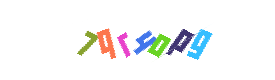

In [12]:
random_idx = np.random.choice(8000)
print(train_data_y[random_idx])
image = cv2.imread(train_data_list[random_idx])

image = cv2.imread('/content/downloaded_files/file1_contents/train/7qr4opg-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/j18w-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/l1hjnwj-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/480c-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/ykjhkmhc-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/7p6te6h-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/cjzjeas-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/rtphiefz-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/r3w8w7m-0.png')
# image = cv2.imread('/content/downloaded_files/file1_contents/train/o1ou-0.png')
image_no_lines = remove_black_pixels_set_to_surrounding(image)

# Create the sharpening kernel
# kernel = np.array([[0, -1, 0], [-1, 4.4, -1], [0, -1, 0]])
# Sharpen the image
# image_no_lines = cv2.filter2D(image_no_lines, -1, kernel)

# image_no_lines = cv2.convertScaleAbs(image_no_lines, alpha=1, beta=1)

# image_no_lines = cv2.resize(image_no_lines, (560, 70), interpolation = cv2.INTER_AREA)

cv2_imshow(image_no_lines)
# cv2_imshow(image)

# cutted = separate_pic(image_no_lines)
# print (len(cutted))

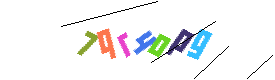

In [ ]:
cv2_imshow(image)

In [13]:
def filter_overlapping_tuples(tuples_list):
    """
    Filter out tuples that overlap with at least 90% with larger tuples.

    Args:
        tuples_list: List of tuples in the form (a, b) where a < b and both are integers

    Returns:
        List of tuples after filtering out those with 90% or more overlap with larger tuples
    """
    if not tuples_list:
        return []

    # Sort tuples by size (b-a) in descending order
    sorted_tuples = sorted(tuples_list, key=lambda t: t[1] - t[0], reverse=True)

    result = []

    for i, (a1, b1) in enumerate(sorted_tuples):
        should_keep = True
        size1 = b1 - a1

        for j, (a2, b2) in enumerate(result):
            size2 = b2 - a2

            # Calculate overlap
            overlap_start = max(a1, a2)
            overlap_end = min(b1, b2)

            if overlap_start < overlap_end:  # There is an overlap
                overlap_size = overlap_end - overlap_start

                # Calculate overlap percentage relative to the current tuple
                overlap_percentage = overlap_size / size1

                if overlap_percentage >= 0.8:  # 90% or more overlap
                    should_keep = False
                    break

        if should_keep:
            result.append((a1, b1))

    return result

In [ ]:
stack_images_horizontally(x)

NameError: name 'x' is not defined

In [ ]:
x = separate_line_white(image_no_lines)
xv = np.hstack(x)
xvs = separate_pic(xv)
# stack_images_horizontally(xvs)

if len(x) > len(xvs) and len(x) < 9:
  fin = x
else:
  fin = xvs

stack_images_horizontally(fin)


In [ ]:
cutted = separate_pic(image_no_lines)
print (len(cutted))
stack_images_horizontally(cutted)
# cv2_imshow(cutted[0])

In [ ]:
get_top_k_colors(separate_line_white(image_no_lines)[3], k=10)

In [14]:
def convert_lists_to_tuples(lists):
    """
    Convert lists of consecutive integers to (min, max) tuples

    Args:
        lists: List of lists, where each inner list contains consecutive integers

    Returns:
        List of tuples (min, max) representing the ranges
    """
    tuples = []
    for lst in lists:
        if lst:  # Ensure list is not empty
            tuples.append((min(lst), max(lst)))
    return tuples

def filter_overlapping_tuples(tuples_list):
    """
    Filter out tuples that overlap with at least 90% with larger tuples.

    Args:
        tuples_list: List of tuples in the form (a, b) where a < b and both are integers

    Returns:
        List of tuples after filtering out those with 90% or more overlap with larger tuples
    """
    if not tuples_list:
        return []

    # Sort tuples by size (b-a) in descending order
    sorted_tuples = sorted(tuples_list, key=lambda t: t[1] - t[0], reverse=True)

    result = []

    for i, (a1, b1) in enumerate(sorted_tuples):
        should_keep = True
        size1 = b1 - a1

        for j, (a2, b2) in enumerate(result):
            size2 = b2 - a2

            # Calculate overlap
            overlap_start = max(a1, a2)
            overlap_end = min(b1, b2)

            if overlap_start <= overlap_end:  # There is an overlap
                overlap_size = overlap_end - overlap_start + 1  # +1 because ranges are inclusive

                # Calculate overlap percentage relative to the current tuple
                overlap_percentage = overlap_size / (size1 + 1)  # +1 because ranges are inclusive

                if overlap_percentage >= 0.9:  # 90% or more overlap
                    should_keep = False
                    break

        if should_keep:
            result.append((a1, b1))

    return result

def process_input_lists(lists):
    """
    Process lists of consecutive integers, convert to tuples, filter overlapping ones,
    and return the filtered tuples.

    Args:
        lists: List of lists, where each inner list contains consecutive integers

    Returns:
        List of tuples after filtering out those with significant overlap
    """
    tuples = convert_lists_to_tuples(lists)
    filtered_tuples = filter_overlapping_tuples(tuples)
    return filtered_tuples

def convert_tuples_to_lists(tuples):
    """
    Convert tuples back to lists of consecutive integers

    Args:
        tuples: List of tuples (min, max) representing ranges

    Returns:
        List of lists, where each inner list contains all integers in the range
    """
    result = []
    for a, b in tuples:
        result.append(list(range(a, b + 1)))  # +1 to include the end value
    return result

In [15]:
def separate_line_white(image_input):
  important = None  # Initialize a variable to store important image data
  important_idx = []  # Initialize a list to store indices of important columns
  height = image_input.shape[1]  # Get the height of the image (though this looks like width based on usage)
  image_avg = image_input.mean(axis=2)  # Calculate average across color channels (converting to grayscale)

  # Iterate through each column of the image
  for i in range(image_input.shape[1]):
      l = image_avg[:, i]  # Get the grayscale values for column i
      l_mean = l.mean()  # Calculate the mean value of the column
      if l_mean <= 254:  # If the mean value is not completely white (allowing for small deviations)
          important_idx.append(i)  # Add this column index to important indices
          if important is not None:
              important = np.vstack([important, l])  # Add column to existing important data
          else:
              important = l  # Initialize important data with this column

  # Group consecutive column indices to identify continuous regions
  groups = group_consecutive(important_idx)
  group_ct = len(groups)  # Count how many separate groups/regions exist
  # print(group_ct)  # Print the number of regions

  clean = list()  # Initialize a list to store processed image regions
  for a, b in groups:
    clean.append(image_input[:, a-3:b+3])
  return clean

def separate_pic(image_input):
  clean = list()  # Initialize a list to store processed image regions

  # Determine how many top colors to analyze
  suspect_amt = filt_top(get_top_k_colors(image_input, 11))
  # print(suspect_amt)  # Print the number of colors to analyze

  color_column_indices_list = []  # Initialize a list to store column indices for each color

  # For each prominent color in the image
  for color_data in get_top_k_colors(image_input, suspect_amt + 1):
      rgb_val = color_data[0]  # Get the RGB value of the color
      if rgb_val == (255, 255, 255):
          continue  # Skip white pixels as they're not informative

      column_indices = []  # Initialize a list to store columns containing this color

      # Check each column for the presence of this color
      for col_idx in range(image_input.shape[1]):
          column = image_input[:, col_idx]  # Extract the column
          for pixel in column:
              if tuple(pixel) == rgb_val:  # Compare the pixel's RGB value to the target color
                  column_indices.append(col_idx)  # If found, record this column
                  break  # Once found in a column, no need to check more pixels in same column

      color_column_indices_list.append(column_indices)  # Add the list of columns for this color

  filtered_tuples = process_input_lists(color_column_indices_list)
  color_column_indices_list = convert_tuples_to_lists(filtered_tuples)

  # Find the leftmost position (minimum index) for each color
  min_list = np.array([])
  for k in color_column_indices_list:
      a = np.min(k)  # Find leftmost position of this color
      b = np.max(k)  # Find rightmost position of this color (not used here)
      min_list = np.append(min_list, a)  # Add the minimum position to our list

  # Sort the colors by their leftmost appearance in the image
  list_of_order = min_list[np.argsort(min_list)]

  # Initialize a list to store image regions, one per color
  clean = [0] * len(color_column_indices_list)

  # Extract image regions for each color based on their sorted order
  for k in color_column_indices_list:
      a = np.min(k)   # Leftmost column for this color
      b = np.max(k)  # Rightmost column for this color
      # print (a, b)
      idx = np.where(list_of_order == a)[0][0]  # Find the position of this color in the sorted order
      # print (type(image_input))
      clean[idx] = image_input[:, max(0, a - 3):min(image_input.shape[1],b + 3)]  # Extract the image region spanning from leftmost to rightmost

  return clean

In [16]:
def whole_prepro(img_path, save_path, saver=False):
  image = cv2.imread(img_path)
  # cv2_imshow(image)
  image_no_lines = remove_black_pixels_set_to_surrounding(image)
  x = separate_line_white(image_no_lines)
  xv = np.hstack(x)
  xvs = separate_pic(xv)

  if len(x) > len(xvs) and len(x) < 9:
    fin = x
  else:
    fin = xvs

  namestr = img_path.split('/')[-1].replace('-0.png','')

  if saver:
    for i, (pic, name) in enumerate(zip(fin, namestr)):
      try:
        cv2.imwrite(os.path.join(save_path, f"pic_{namestr}_{i}_{name}.png"), pic)
      except Exception as e:
        continue
  else:
    pass

  return fin

### rule-based cut

In [ ]:
import os
from tqdm import tqdm

def process_images_with_tqdm(train_data_list, train_data_y, save_path_train, tolerance=4):
    """Processes images using cut_images and displays progress with tqdm."""

    errors = 0
    for file_path, file_name in tqdm(zip(train_data_list, train_data_y), total=len(train_data_list), desc="Processing images"):
        list_of_label = list(file_name)
        if len(list_of_label) != len(whole_prepro(file_path, save_path_train)):
          errors += 1
          print(errors)
        else:
          whole_prepro(file_path, save_path_train, saver=True)

    return errors

save_path_train = "train_crops"

# Ensure the output directory exists
os.makedirs(save_path_train, exist_ok=True)

errors_count = process_images_with_tqdm(test_data_list, test_data_y, save_path_train)

print(f"Total errors: {errors_count}")

Processing images:   0%|          | 2/2000 [00:00<07:19,  4.54it/s]

1


Processing images:   1%|          | 19/2000 [00:05<11:21,  2.91it/s]

2


Processing images:   1%|          | 23/2000 [00:06<08:40,  3.80it/s]

3


Processing images:   2%|▏         | 38/2000 [00:10<07:22,  4.44it/s]

4


Processing images:   2%|▏         | 49/2000 [00:12<05:30,  5.91it/s]

5


Processing images:   4%|▎         | 72/2000 [00:22<09:23,  3.42it/s]

6


Processing images:   4%|▍         | 77/2000 [00:23<06:33,  4.88it/s]

7


Processing images:   4%|▍         | 86/2000 [00:25<06:12,  5.14it/s]

8


Processing images:   6%|▌         | 110/2000 [00:35<12:02,  2.62it/s]

9


Processing images:   6%|▌         | 121/2000 [00:40<10:36,  2.95it/s]

10


Processing images:   6%|▋         | 128/2000 [00:42<06:57,  4.48it/s]

11


Processing images:   8%|▊         | 153/2000 [00:51<08:10,  3.76it/s]

12


Processing images:   8%|▊         | 155/2000 [00:51<09:14,  3.33it/s]

13


Processing images:   8%|▊         | 169/2000 [00:56<16:16,  1.88it/s]

14


Processing images:   8%|▊         | 170/2000 [00:56<17:02,  1.79it/s]

15


Processing images:   9%|▊         | 171/2000 [00:57<14:45,  2.06it/s]

16


Processing images:   9%|▉         | 176/2000 [00:58<09:29,  3.20it/s]

17


Processing images:  10%|█         | 209/2000 [01:07<06:42,  4.45it/s]

18


Processing images:  11%|█▏        | 225/2000 [01:12<06:17,  4.70it/s]

19


Processing images:  12%|█▏        | 245/2000 [01:18<12:12,  2.39it/s]

20


Processing images:  13%|█▎        | 263/2000 [01:24<07:27,  3.88it/s]

21


Processing images:  14%|█▎        | 271/2000 [01:26<09:15,  3.11it/s]

22


Processing images:  15%|█▍        | 293/2000 [01:33<08:02,  3.54it/s]

23


Processing images:  15%|█▍        | 297/2000 [01:34<09:53,  2.87it/s]

24


Processing images:  15%|█▍        | 299/2000 [01:35<09:10,  3.09it/s]

25


Processing images:  15%|█▌        | 303/2000 [01:36<08:44,  3.24it/s]

26


Processing images:  16%|█▋        | 326/2000 [01:43<07:42,  3.62it/s]

27
28


Processing images:  17%|█▋        | 348/2000 [01:49<04:30,  6.11it/s]

29
30


Processing images:  18%|█▊        | 359/2000 [01:53<06:38,  4.11it/s]

31


Processing images:  20%|█▉        | 396/2000 [02:05<07:47,  3.43it/s]

32


Processing images:  20%|█▉        | 399/2000 [02:06<05:22,  4.96it/s]

33


Processing images:  22%|██▏       | 439/2000 [02:20<05:46,  4.50it/s]

34


Processing images:  22%|██▏       | 444/2000 [02:21<07:54,  3.28it/s]

35


Processing images:  23%|██▎       | 459/2000 [02:26<06:36,  3.89it/s]

36


Processing images:  23%|██▎       | 461/2000 [02:27<05:25,  4.72it/s]

37
38


Processing images:  24%|██▎       | 470/2000 [02:29<06:44,  3.78it/s]

39


Processing images:  24%|██▎       | 473/2000 [02:30<07:34,  3.36it/s]

40


Processing images:  24%|██▍       | 475/2000 [02:31<06:26,  3.95it/s]

41


Processing images:  24%|██▍       | 481/2000 [02:32<06:21,  3.98it/s]

42


Processing images:  24%|██▍       | 485/2000 [02:33<06:42,  3.76it/s]

43


Processing images:  25%|██▍       | 492/2000 [02:35<05:52,  4.28it/s]

44


Processing images:  25%|██▌       | 507/2000 [02:40<04:59,  4.99it/s]

45
46


Processing images:  26%|██▌       | 512/2000 [02:41<05:32,  4.47it/s]

47


Processing images:  26%|██▌       | 521/2000 [02:43<05:25,  4.54it/s]

48


Processing images:  26%|██▌       | 523/2000 [02:44<05:59,  4.11it/s]

49


Processing images:  26%|██▌       | 524/2000 [02:44<06:04,  4.05it/s]

50


Processing images:  27%|██▋       | 537/2000 [02:48<06:29,  3.76it/s]

51


Processing images:  28%|██▊       | 562/2000 [02:56<06:38,  3.61it/s]

52


Processing images:  28%|██▊       | 565/2000 [02:57<05:02,  4.74it/s]

53
54


Processing images:  29%|██▊       | 571/2000 [02:58<03:32,  6.72it/s]

55
56


Processing images:  29%|██▉       | 578/2000 [02:59<05:02,  4.70it/s]

57


Processing images:  30%|███       | 601/2000 [03:07<05:25,  4.29it/s]

58


Processing images:  30%|███       | 608/2000 [03:09<05:24,  4.29it/s]

59


Processing images:  31%|███       | 619/2000 [03:12<05:17,  4.35it/s]

60


Processing images:  31%|███       | 621/2000 [03:12<04:56,  4.66it/s]

61


Processing images:  33%|███▎      | 661/2000 [03:25<06:48,  3.27it/s]

62


Processing images:  33%|███▎      | 665/2000 [03:26<06:19,  3.52it/s]

63


Processing images:  34%|███▎      | 673/2000 [03:28<06:49,  3.24it/s]

64


Processing images:  34%|███▍      | 685/2000 [03:33<07:48,  2.81it/s]

65


Processing images:  34%|███▍      | 690/2000 [03:34<05:54,  3.70it/s]

66


Processing images:  35%|███▍      | 698/2000 [03:36<04:29,  4.84it/s]

67


Processing images:  35%|███▌      | 705/2000 [03:38<05:20,  4.04it/s]

68


Processing images:  36%|███▌      | 710/2000 [03:39<04:21,  4.94it/s]

69


Processing images:  36%|███▌      | 716/2000 [03:42<07:50,  2.73it/s]

70


Processing images:  36%|███▌      | 721/2000 [03:43<04:50,  4.40it/s]

71


Processing images:  37%|███▋      | 740/2000 [03:48<04:37,  4.54it/s]

72


Processing images:  37%|███▋      | 747/2000 [03:50<03:40,  5.68it/s]

73


Processing images:  38%|███▊      | 754/2000 [03:53<06:28,  3.20it/s]

74


Processing images:  38%|███▊      | 763/2000 [04:00<17:29,  1.18it/s]

75


Processing images:  39%|███▉      | 789/2000 [04:17<04:58,  4.06it/s]

76


Processing images:  40%|███▉      | 797/2000 [04:21<08:35,  2.33it/s]

77


Processing images:  40%|████      | 800/2000 [04:21<04:55,  4.06it/s]

78
79


Processing images:  40%|████      | 805/2000 [04:22<04:21,  4.57it/s]

Errors 861/8010

## Model

In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
from transformers import AutoImageProcessor
from transformers import Trainer, TrainingArguments

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [19]:
!pip install -q datasets

In [20]:
from datasets import Dataset


In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image

# Fix the path construction
base_path = '/content/train_crops/content/train_crops'
image_files = os.listdir(base_path)

# Create proper file paths and extract labels
file_paths = []
labels = []

for filename in image_files:
    # Only process image files
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Full path to the image
        full_path = os.path.join(base_path, filename)
        file_paths.append(full_path)

        # Extract label from filename - assuming the label is the character before the file extension
        # Adjust this logic based on your actual filename format
        label = os.path.splitext(filename)[0].split('_')[-1]  # Example: if format is "image_pizza.jpg" -> "pizza"
        labels.append(label)

# Create DataFrame
images_df = pd.DataFrame({
    'path': file_paths,
    'label': labels
})

# Check the dataset
print(f"Total images found: {len(images_df)}")
print(images_df.head())

# Count images per class
print("\nClass distribution:")
print(images_df['label'].value_counts())

# Convert labels to numeric IDs for model training
unique_labels = images_df['label'].unique()
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Add numeric label IDs to DataFrame
images_df['label_id'] = images_df['label'].map(label_to_id)

# Split into train and evaluation sets (80% train, 20% eval)
train_df, eval_df = train_test_split(
    images_df,
    test_size=0.2,
    stratify=images_df['label'],  # Maintain class distribution
    random_state=42
)

print(f"\nTraining set: {len(train_df)} images")
print(f"Evaluation set: {len(eval_df)} images")


def preprocess_images(examples):
    images = [Image.open(path).convert("RGB") for path in examples["path"]]
    processed_images = image_processor(images, return_tensors="pt")
    examples["pixel_values"] = processed_images.pixel_values
    # Don't move to device here - let the DataLoader/Trainer handle this
    return examples

# Create Hugging Face Datasets
def create_dataset(dataframe):
    # Convert pandas DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(dataframe)

    # Map preprocessing function to the dataset
    dataset.set_transform(preprocess_images)

    return dataset

# Load image processor
model_checkpoint = "google/vit-base-patch16-224"  # Example checkpoint, replace with your preferred model
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Create datasets for training
train_dataset = create_dataset(train_df)
eval_dataset = create_dataset(eval_df)

# Function to compute metrics during training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

# First, check if GPU is available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Modify your dataset preparation to NOT move tensors to GPU in the preprocessing step
# The Trainer will handle moving data to the GPU


# Update your collate function to NOT move tensors to the device
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["label_id"] for example in batch])
    # Don't move to device here - let the Trainer handle this
    return {"pixel_values": pixel_values, "labels": labels}

# Update your training arguments
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    # Use DataLoader setting to control pinning
    dataloader_pin_memory=True,  # This enables pinning CPU memory
    fp16=True,                   # Keep mixed precision training
)

# Make sure model is created but NOT moved to device manually
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    id2label=id_to_label,
    label2id=label_to_id,
    ignore_mismatched_sizes=True
)
# Don't do model = model.to(device) - Trainer will handle this

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Total images found: 42995
                                                path label
0  /content/train_crops/content/train_crops/pic_s...     s
1  /content/train_crops/content/train_crops/pic_j...     z
2  /content/train_crops/content/train_crops/pic_7...     y
3  /content/train_crops/content/train_crops/pic_f...     o
4  /content/train_crops/content/train_crops/pic_a...     n

Class distribution:
label
e    1237
n    1235
x    1234
3    1230
p    1229
g    1227
d    1223
b    1222
o    1219
f    1217
q    1216
k    1216
9    1210
0    1207
6    1205
h    1202
c    1198
1    1197
v    1193
t    1191
m    1190
w    1189
z    1189
4    1187
u    1184
l    1184
s    1175
r    1173
8    1169
a    1169
i    1160
5    1157
y    1149
7    1148
2    1134
j    1130
Name: count, dtype: int64

Training set: 34396 images
Evaluation set: 8599 images


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([36]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([36, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.489000,0.497800,0.852890
2,0.268500,0.364552,0.885684
3,0.071400,0.301159,0.906152


TrainOutput(global_step=2148, training_loss=0.5289574991946335, metrics={'train_runtime': 1694.2342, 'train_samples_per_second': 81.207, 'train_steps_per_second': 1.268, 'total_flos': 1.0647853406581064e+19, 'train_loss': 0.5289574991946335, 'epoch': 3.993488372093023})

In [24]:
# --- Assuming you have a directory 'test_crops' with your test images ---
test_base_path = '/content/test_crops/content/train_crops'  # Adjust this path
test_image_files = os.listdir(test_base_path)

test_file_paths = []
test_labels = []

for filename in test_image_files:
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_path = os.path.join(test_base_path, filename)
        test_file_paths.append(full_path)
        # Extract label - adapt this to your test data's filename structure
        test_label = os.path.splitext(filename)[0].split('_')[-1]
        test_labels.append(test_label)

test_df = pd.DataFrame({
    'path': test_file_paths,
    'label': test_labels
})

# Map labels to numeric IDs using the *same* mapping from training
test_df['label_id'] = test_df['label'].map(label_to_id)

test_dataset = create_dataset(test_df)

In [35]:
eval_dataset

Dataset({
    features: ['path', 'label', 'label_id', '__index_level_0__'],
    num_rows: 8599
})

In [25]:
# Temporarily set the eval_dataset to your test_dataset
trainer.eval_dataset = test_dataset

# Evaluate on the test dataset
test_metrics = trainer.evaluate()

print("\nEvaluation metrics on the test dataset:")
print(test_metrics)

# Optionally, revert the eval_dataset if you need it later
trainer.eval_dataset = eval_dataset


Evaluation metrics on the test dataset:
{'eval_loss': 0.2840859591960907, 'eval_accuracy': 0.9098751835535976, 'eval_runtime': 51.76, 'eval_samples_per_second': 210.51, 'eval_steps_per_second': 13.157, 'epoch': 3.993488372093023}


## Ok


In [20]:
!unzip test.zip -d /content/test_crops/

Streaming output truncated to the last 5000 lines.
  inflating: /content/test_crops/content/train_crops/pic_i9n9a_1_9.png  
  inflating: /content/test_crops/content/train_crops/pic_6887qv_5_v.png  
  inflating: /content/test_crops/content/train_crops/pic_fooa1y_0_f.png  
  inflating: /content/test_crops/content/train_crops/pic_0wy4otel_6_e.png  
  inflating: /content/test_crops/content/train_crops/pic_nih4y1e_5_1.png  
  inflating: /content/test_crops/content/train_crops/pic_dnstkc6_2_s.png  
  inflating: /content/test_crops/content/train_crops/pic_cdavw_4_w.png  
  inflating: /content/test_crops/content/train_crops/pic_kfizs5_5_5.png  
  inflating: /content/test_crops/content/train_crops/pic_08sba_3_b.png  
  inflating: /content/test_crops/content/train_crops/pic_gmlevzei_5_z.png  
  inflating: /content/test_crops/content/train_crops/pic_ibx6gub_3_6.png  
  inflating: /content/test_crops/content/train_crops/pic_r2nk80r_0_r.png  
  inflating: /content/test_crops/content/train_crops/pic

In [19]:
!unzip train.zip -d /content/train_crops/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train_crops/content/train_crops/pic_j4bgpn_4_p.png  
  inflating: /content/train_crops/content/train_crops/pic_z487ufh_5_f.png  
  inflating: /content/train_crops/content/train_crops/pic_mq639gkf_3_3.png  
  inflating: /content/train_crops/content/train_crops/pic_grz2t_1_r.png  
  inflating: /content/train_crops/content/train_crops/pic_aoe2bt_3_2.png  
  inflating: /content/train_crops/content/train_crops/pic_0fn5eioh_3_5.png  
  inflating: /content/train_crops/content/train_crops/pic_9966_3_6.png  
  inflating: /content/train_crops/content/train_crops/pic_2ilolokm_3_o.png  
  inflating: /content/train_crops/content/train_crops/pic_wbp4exp_1_b.png  
  inflating: /content/train_crops/content/train_crops/pic_ee8srco_2_8.png  
  inflating: /content/train_crops/content/train_crops/pic_uz67y9_1_z.png  
  inflating: /content/train_crops/content/train_crops/pic_ql2ffv_3_f.png  
  inflating: /content/train_crops/content/t

In [21]:
os.mkdir('/content/ocr_model')